# Equation Game v3
- Edited 7 Aug 2024
    - Added better labels for graph
    
- 29 Jul 2024
    - Added Gradio Integration
    - Tuned Level Difficulties

- Created by John: 27 Jul 2024
- This uses the ConversableAgent class of TaskGen to do a game of guessing the equation with the user

In [1]:
import os
import matplotlib.pyplot as plt
import sympy as sp
import numpy as np
import plotly.graph_objects as go
import gradio as gr
import random
import time
from IPython.display import clear_output, display

os.environ['OPENAI_API_KEY'] = '<YOUR API KEY HERE>'

In [2]:
from taskgen import *

In [3]:
def llm(system_prompt: str, user_prompt: str) -> str:
    ''' Here, we use OpenAI for illustration, you can change it to your own LLM '''
    # ensure your LLM imports are all within this function
    from openai import OpenAI
    
    # define your own LLM here
    client = OpenAI()
    response = client.chat.completions.create(
        model='gpt-4o-mini',
        temperature = 0,
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt}
        ]
    )
    return response.choices[0].message.content

# Generates a random equation and random coordinates 

In [4]:
def generate_equation_and_coordinates(level = 1):
    random.seed(time.time())
    a, b, c = 0, 0, 0
    # Generate non-zero terms
    while a == 0:
        a = random.randint(-3, 3)
    while b == 0:
        b = random.randint(-5, 5)
    while c == 0:
        c = random.randint(-10, 10)
    
    # Level 1 - only constant term
    if level == 1:
        a, b = 0, 0
    # Level 2 - only gradient term
    elif level == 2:
        a, c = 0, 0
    # Level 3 - constant plus gradient term
    elif level == 3:
        a = 0
    # Level 4 - only quadratic term
    elif level == 4:
        b, c = 0, 0
    # Level 5 - quadratic plus constant term
    elif level == 5:
        b = 0
    # Level 6 - quadratic plus gradient term
    elif level == 6:
        c = 0
    # Level 7 - everything        
    
    coordinates = set()
    while len(coordinates) < 5:
        x = random.randint(-10, 10)
        y = a * x**2 + b * x + c
        coordinates.add((x, y))
        
    # Construct the equation string
    equation_parts = []
    if a != 0:
        equation_parts.append(f"{a}*x**2" if a != 1 else "x**2")
    if b != 0:
        sign_b = "+" if b > 0 else "-"
        equation_parts.append(f"{sign_b} {abs(b)}*x" if b != 1 else f"{sign_b} x")
    if c != 0:
        sign_c = "+" if c > 0 else "-"
        equation_parts.append(f"{sign_c} {abs(c)}")
    
    equation = "y = " + " ".join(equation_parts).replace("+ -", "- ")
    
    # Remove leading '+' if present
    if equation.startswith("y = + "):
        equation = equation.replace("y = + ", "y = ")
    
    return equation, list(coordinates)

In [5]:
equation, coordinates = generate_equation_and_coordinates()

In [6]:
coordinates

[(0, -3), (9, -3), (-3, -3), (-7, -3), (1, -3)]

# Plot Coordinates and Equations

In [11]:
def plot_coordinates_and_equations(coordinates, equations):
    ''' Returns a figure that contains the coordinates and equations '''
    # Extract x and y values from coordinates
    x_values, y_values = zip(*coordinates)
    
    # Define the variable
    x = sp.symbols('x')
    
    # Create a figure
    fig = go.Figure()

    # Add the scatter plot of the coordinates
    fig.add_trace(go.Scatter(
        x=x_values, y=y_values, mode='markers', name='Coordinates',
        marker=dict(color='blue', size=8)
    ))
    
    # Define the range for plotting equations
    x_min, x_max = min(x_values), max(x_values)
    y_min, y_max = min(y_values), max(y_values)
    x_range = np.linspace(x_min - 1, x_max + 1, 400)
    
    # Plot each equation
    for eq in equations:
        original_eq = eq
        # Parse the equation
        if '=' in eq:
            eq = eq.split('=')[1].strip()
        
        # Check if the equation is a constant
        try:
            y_value = float(eq)
            y_range = np.full_like(x_range, y_value)
            label = f'y = {y_value}'
        except ValueError:
            y_expr = sp.sympify(eq)
            y_func = sp.lambdify(x, y_expr, 'numpy')
            y_range = y_func(x_range)
            label = original_eq
        
        # Add the equation plot
        fig.add_trace(go.Scatter(
            x=x_range, y=y_range, mode='lines', name=label
        ))
    
    # Update layout with title and labels
    fig.update_layout(
        title='Scatter Plot of Coordinates and Equations',
        xaxis_title='x values',
        yaxis_title='y values',
        xaxis=dict(autorange=True),
        yaxis=dict(autorange=True),
        legend=dict(x=0.01, y=0.99, traceorder='normal'),
        width=800,
        height=600
    )
    
    return fig

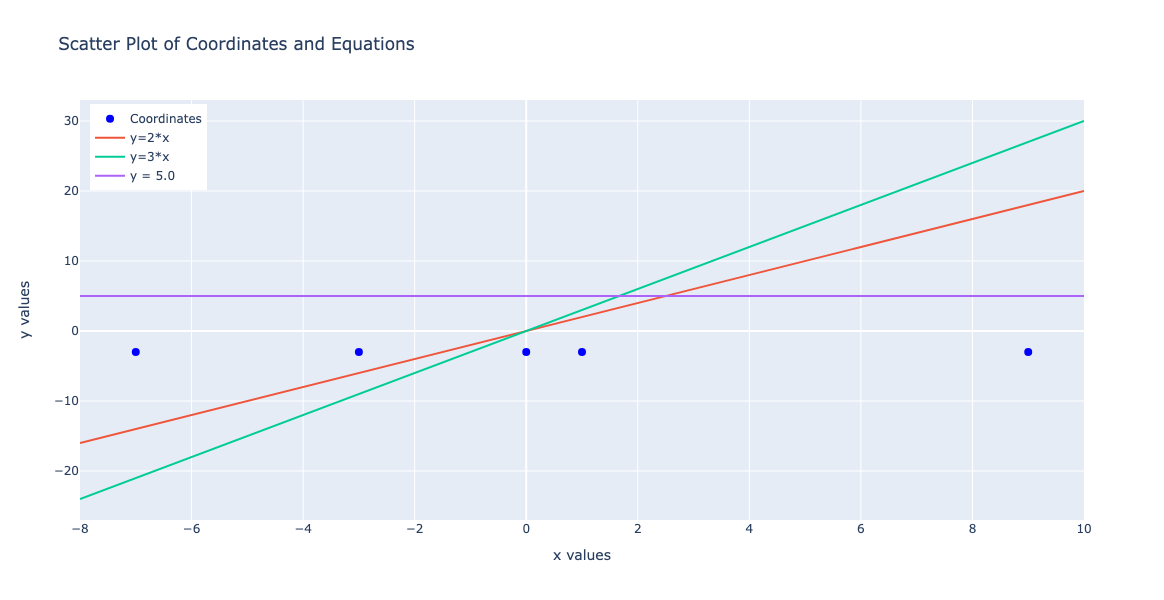

In [12]:
plot_coordinates_and_equations(coordinates, ['y=2*x', 'y=3*x', 'y=5'])

# Basic - Using Jupyter Lab to play the game

In [13]:
def play_game():
    for level in range(1, 8):
        # Clear the output
        # clear_output(wait=True)

        print(f'### Level {level} ###\n')

        equation, coordinates = generate_equation_and_coordinates(level = level)

        print(f'Try to guess the equation that fits the following points: {coordinates}\nHere is the graph:')

        display(plot_coordinates_and_equations(coordinates, []))

        agent = Agent('Math Tutor', 
    '''Based on the equation given by the user, guide the user to the correct equation that matches the (x, y) coordinates without giving away the answer.
Never ever give the actual equation to the user.
If the equation is not of the form y = f(x), guide user to correct the equation to make it of that form.
When user answers correctly, give an example of how this equation can be used in a situation''',
                      llm = llm,
                      shared_variables = {"equation": equation, "coordinates": coordinates},
                     global_context = "Correct Equation: <equation>\nCoordinates: <coordinates>")

        my_agent = ConversableAgent(agent, 
                     persistent_memory = {'User Provided Correct Equation': 'type: bool'})

        equation_list = []

        # Set up the conversation
        while True:
            user_input = input('User: ')
            if user_input == 'exit': return

            res = strict_json('''Extract an equation from User Input that can be evaluated by sp.sympify() with only x as the variable or just constant, e.g. y=exp(1)^3, y=3*x**2+4*x-3, y=2*x, y=3.
If User Input is not an equation, but some instructions to modify previous equations, e.g. increase constant by 1, output the modified equation based on applying User Input to the last equation
If User Input has a ?, remove it before putting into equation, e.g. y=3? -> y=3
Output NA if not able to extract''',
                              f'Last Equation: {None if len(equation_list) == 0 else equation_list[-1]}\n User Input: {user_input}',
                              output_format = {'Equation': 'type: str'},
                              llm = llm)
            user_equation = res["Equation"].replace(" ","")

            if 'NA' not in user_equation:
                user_input = user_equation

            reply = my_agent.chat(user_input)   

            try:
                if 'NA' not in user_equation:
                    equation_list.append(user_equation)
                    # Display the graph
                    print('Here is the graph with past two equations:')
                    display(plot_coordinates_and_equations(coordinates, equation_list[-2:]))
                if agent.shared_variables['Persistent Memory']['User Provided Correct Equation']:
                    break

            except Exception as e:
                print('Error message', e)
                print('Error parsing equation: Ensure that your equation is of the form y = f(x)')

            # print out agent's reply
            print(my_agent.agent.agent_name + ':', reply)
            print()

### Level 1 ###

Try to guess the equation that fits the following points: [(4, 4), (-4, 4), (-9, 4), (2, 4), (-5, 4)]
Here is the graph:


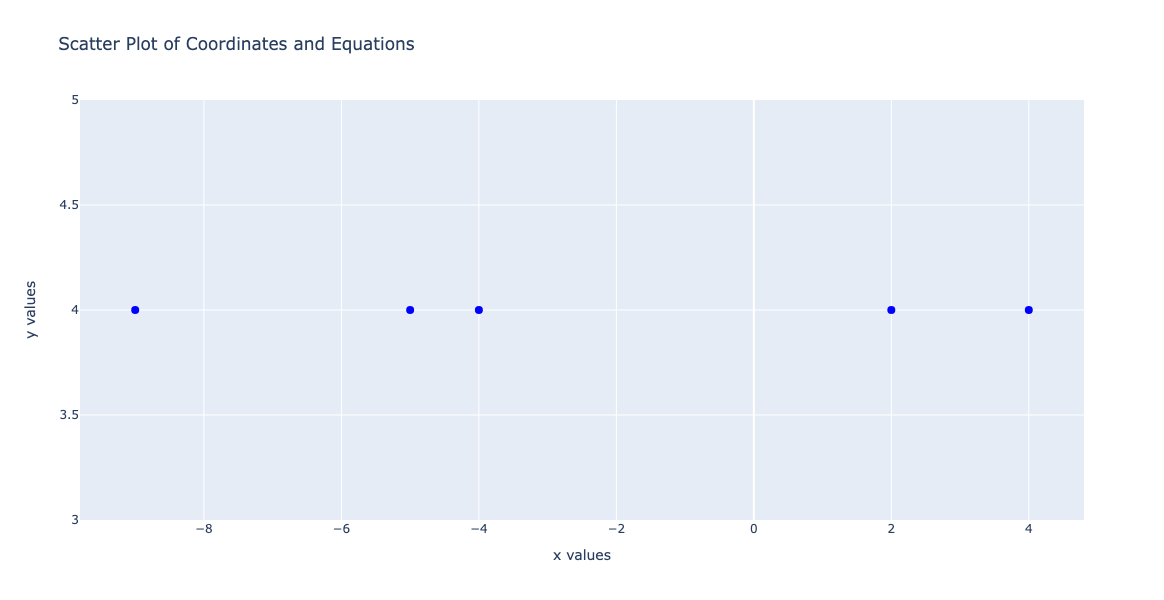

User:  y= 7


Thoughts: The user has provided an equation that does not match the coordinates given. I need to guide them to understand that the correct equation should be of the form y = f(x) and that the y-value should be constant for all x-values in the provided coordinates.
Persistent Memory: {'User Provided Correct Equation': False}
Summary of Conversation: The user initially provided an equation y = 7, which does not match the coordinates given. I guided them to consider an equation that would yield a constant y-value of 4 for all x-values in the provided coordinates.
Here is the graph with past two equations:


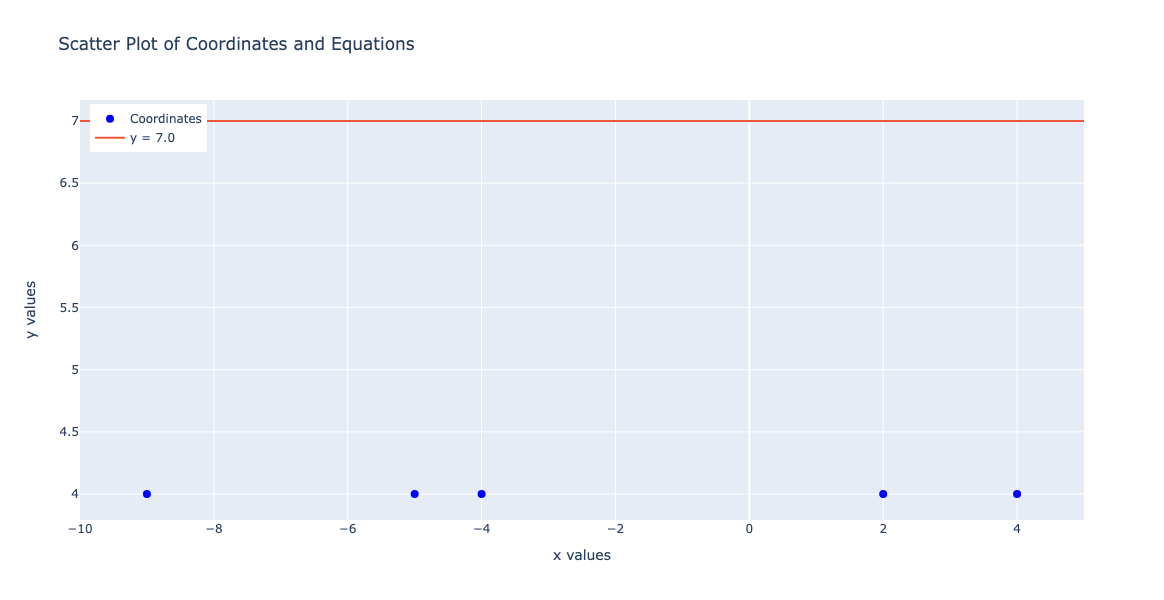

Math Tutor: It looks like the equation you provided, y = 7, does not match the coordinates we have. Notice that all the y-values in the coordinates are 4. Can you think of an equation that would have a constant y-value of 4 for all x-values?



KeyboardInterrupt: Interrupted by user

In [14]:
play_game()

# Advanced - Using Gradio

In [15]:
def process_user_input(level, user_input, my_agent, agent, equation_list):
    res = strict_json('''Extract an equation from User Input that can be evaluated by sp.sympify() with only x as the variable or just constant, e.g. y=exp(1)^3, y=3*x**2+4*x-3, y=2*x, y=3. 
If User Input is not an equation, but some instructions to modify previous equations, e.g. increase constant by 1, output the modified equation based on applying User Input to the last equation
If User Input has a ?, remove it before putting into equation, e.g. y=3? -> y=3
Output NA if not able to extract''',
                      f'Last Equation: {None if len(equation_list) == 0 else equation_list[-1]}\n User Input: {user_input}',
                      output_format = {'Equation': 'type: str'},
                      llm = llm)
    user_equation = res["Equation"].replace(" ","")
    
    if 'NA' not in user_equation:
        user_input = user_equation
    reply = my_agent.chat(user_input)   

    if 'NA' not in user_equation:
        equation_list.append(user_equation)

    fig = plot_coordinates_and_equations(agent.shared_variables["coordinates"], equation_list[-2:])
    return reply, fig

In [16]:
def chat(user_input, level):
    global equation_list, my_agent, agent
    reply, fig = process_user_input(level, user_input, my_agent, agent, equation_list)
    if agent.shared_variables["Persistent Memory"]["User Provided Correct Equation"]:
        level += 1
        if level > 7:
            level = 7
        equation_list = []
        return f'Correct! You can now proceed to Level {level}', fig
    return reply, fig

In [17]:
# Function to generate default graph
def generate_default_graph(coordinates):
    return "Try to guess the equation of the form y = f(x) that fits the following points:", plot_coordinates_and_equations(coordinates, [])

In [18]:
def initialize_agent(level):
    equation, coordinates = generate_equation_and_coordinates(level=level)
    agent = Agent('Math Tutor', 
        '''Based on the equation given by the user, guide the user to the correct equation that matches the (x, y) coordinates without giving away the answer.
Never ever give the actual equation to the user.
If the equation is not of the form y = f(x), guide user to correct the equation to make it of that form.
When user answers correctly, give an example of how this equation can be used in a situation''',
                    llm = llm,
                    shared_variables = {"equation": equation, "coordinates": coordinates},
                   global_context = "Correct Equation: <equation>\nCoordinates: <coordinates>")
    my_agent = ConversableAgent(agent, persistent_memory = {'User Provided Correct Equation': 'type: bool'})
    return agent, my_agent, coordinates

In [19]:
def update_level(level):
    global equation_list, my_agent, agent
    equation_list = []
    agent, my_agent, coordinates = initialize_agent(level)
    intro_text, default_plot = generate_default_graph(coordinates)
    return intro_text, default_plot

In [20]:
# Initialize default values
level = 1
equation_list = []
agent, my_agent, coordinates = initialize_agent(level)
intro_text, default_plot = generate_default_graph(coordinates)

with gr.Blocks() as demo:
    with gr.Row():
        with gr.Column(scale=6):
            game_text = gr.Markdown("# Guess The Equation! #")
        with gr.Column(scale=1):
            level_text = gr.Markdown("# Current Level: #")
        with gr.Column(scale=1):
            level_dropdown = gr.Dropdown(choices=list(range(1, 8)), label="Current Level", value=level, container = False)
    with gr.Row():
        with gr.Column(scale=10):
            user_input = gr.Textbox(lines=1, placeholder="Type your equation or modification here...", label="Your Input", container = False)
        with gr.Column(scale=1):
            submit_btn = gr.Button("Submit")
    
    output_text = gr.Textbox(lines = 2, value=intro_text, label="Agent's Reply")
    output_plot = gr.Plot(value=default_plot)
    
    level_dropdown.change(update_level, inputs=level_dropdown, outputs=[output_text, output_plot])
    submit_btn.click(chat, inputs=[user_input, level_dropdown], outputs=[output_text, output_plot])

demo.launch()

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


Thoughts: The user suggested an equation in the form of x = 4, which is not in the desired form of y = f(x). I need to guide them to understand that the correct form should express y in terms of x.
Persistent Memory: {'User Provided Correct Equation': False}
Summary of Conversation: The user suggested an equation x = 4, which is not in the correct form. I guided them to express the equation in the form of y = f(x) instead.
Thoughts: The user suggested y = 4, which does not match the y-coordinates of the provided points. I need to guide them to find the correct equation that fits the coordinates.
Persistent Memory: {'User Provided Correct Equation': False}
Summary of Conversation: The user suggested an equation y = 4, which does not match the y-coordinates of the provided points. I guided them to find an equation that correctly represents the y-value of 3 for the given coordinates.
Thoughts: The user has suggested an equation y = 3.5, which does not match the y-coordinates of the provid